In [1]:
# dit is voor directory binnen google colab
%cd drive/MyDrive/Colab\ Notebooks

/content/drive/MyDrive/Colab Notebooks


In [2]:
# nog toe te voegen voor wie lokaal runt
# is GPU toevoeging.....

In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
import pandas as pd
import os
import glob
from matplotlib import pyplot as plt

In [3]:
train_df = pd.read_csv("train_labels.csv")

In [4]:
# retrieve label for image
def get_image_label(image_name, train_df):
  return train_df[train_df.img_name == image_name].label.values[0]

# transform image
def image_to_feature(image, size=(150,150)):
  # resize image to size
  width, height = image.shape[1], image.shape[0]
  mid_w, mid_h = int(width/2), int(height/2)
  image = image[mid_h-75:mid_h+75, mid_w-75:mid_w+75]

  # normalize and flatten image
  image = cv2.normalize(image, image)
  image = image.flatten()
  return image

In [5]:
train_df.label.value_counts()

71    525
37    494
57    491
61    490
9     489
     ... 
59    278
78    274
67    257
42    255
20     27
Name: label, Length: 80, dtype: int64

In [ ]:
%%time
# change list directory if necessary
image_paths_train = ["train_set/"+file for file in os.listdir("train_set")]

raw_images = []
labels = []

for i, image_path in enumerate(image_paths_train):
  image = cv2.imread(image_path)
  
  # try to get label, will be corected later if something goes wrong
  try: 
    label = get_image_label(image_path[10:], train_df)
  except:
    label = "niet"

  features = image_to_feature(image)
  
  raw_images.append(features)
  labels.append(label)

  # show update every 100 images
  if i > 0 and i % 100 == 0:
    print("Processed {}/{}".format(i, len(image_paths_train)))
  if i >0 and i % 500 == 0:
    print("{} done, {} more to go".format(i, len(image_paths_train-i)))

Processed 100/30620
Processed 200/30620
Processed 300/30620


In [6]:
labels_2 = []

for i, number in enumerate(labels):
  if number == "niet":
    print(i, train_df[train_df.img_name == "train_"+ str(i+1) + ".jpg"].label.values[0])
    labels_2.append(train_df[train_df.img_name == "train_"+ str(i+1) + ".jpg"].label.values[0])

  else:
    labels_2.append(number)

24204 35
24211 22
24213 9
24215 61
24217 62
24219 66
24225 42
24233 32


In [7]:
# split data into train and validate
trainRI, testRI, trainL, testL = train_test_split(raw_images, labels_2, test_size=0.1, random_state=20)

In [8]:
def get_model_accuracy(k, train_images, test_images, train_label, test_label):
  model = KNeighborsClassifier(n_neighbors=k)
  model.fit(train_images, train_label)
  acc = model.score(test_images, test_label)
  return acc

In [9]:
import joblib

In [ ]:
%%time
model = KNeighborsClassifier(n_neighbors=1)
model.fit(trainRI, trainL)
acc = model.score(testRI, testL)
print(acc)

# joblib.dump(model, "models/knn_n_1.sav")

# loaded_model = joblib.load("models/knn_n_1.sav")
# acc = loaded_model.score(testRI, testL)
# print(acc)

In [ ]:
%%time
accuracy_k = []

# fit model for vaious of k, get accuracy
for k in range(1,51):
  acc = get_model_accuracy(k, trainRI, testRI, trainL, testL)
  # print("raw image accuracy for k = {}: {:.2f}%".format(k, acc*100))
  accuracy_k.append([k, acc])

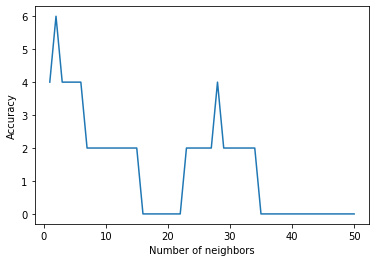

Highest acc of 6.0, with 2 neighbours


In [ ]:
# plot accuracy_k
x_labels = [item[0] for item in accuracy_k]
y_labels = [item[1] for item in accuracy_k]
plt.plot(x_labels, y_labels)
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

# get top accuracy lowest k or highest k
top_k = max(accuracy_k, key=lambda x:x[1])
print("Highest acc of {}, with {} neighbours".format(top_k[1], top_k[0]))

In [ ]:
# process all test images
image_path_test = ["test_set/"+file for file in os.listdir("test_set")]

test_images = []

for i, image_path in enumerate(image_path_test):
  image = cv2.imread(image_path)
  features = image_to_feature(image)
  test_images.append(features)

  # show update every 100 images
  if i > 0 and i % 100 == 0:
    print("Processed {}/{}".format(i, len(image_paths)))

Processed 100/500
Processed 200/500


In [ ]:
# get predictions for our choice of k
model = KNeighborsClassifier(n_neighbors=top_k[0])
model.fit(trainRI, trainL)
predictions = model.predict(test_images)

# put prediction csv together
image_names = [image[9:] for image in image_path_test]

data = list(zip(image_names, predictions))
df = pd.DataFrame(data, columns=['img_name', 'label']).sort_values(by='img_name')

# put test labels in csv file
#df.to_csv("predictions/predictions_knn.csv")

In [ ]:
df

,img_name,label
8,test_1.jpg,35
21,test_10.jpg,37
9,test_100.jpg,1
20,test_1000.jpg,24
16,test_1001.jpg,30
...,...,...
237,test_1232.jpg,45
250,test_1233.jpg,24
235,test_1234.jpg,24
239,test_1235.jpg,8
